In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns

In [9]:
%matplotlib inline

In [28]:
pp.style.use('seaborn-white')
sns.set_palette("muted")
plot_size = 6*np.array([1.0,(2.0/(1.0+np.sqrt(5.0)))]) #Use Golden ratio as aspect ratio for plots

In [25]:
al_0_844_MeV_state = pd.read_csv("data/al_0.844MeV_excited_state.dat")

In [26]:
test_Q = al_0_844_MeV_state.Q_eff[al_0_844_MeV_state.theta < 160.0]
test_f = al_0_844_MeV_state.f_total_sq[al_0_844_MeV_state.theta < 160.0]

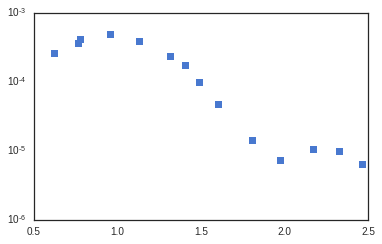

In [29]:
pp.figure(figsize=plot_size)
pp.errorbar(test_Q,test_f, ls='None', marker='s')
pp.yscale('log')
pp.show()

In [23]:
len(test_f)

14